<a href="https://colab.research.google.com/github/emish8/Converting-Photos-to-Monet-Style-Paintings-Using-GANs/blob/main/Cycle_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Neural Style Transfer to Convert Photo to Monet Style Painting

ref: https://www.tensorflow.org/tutorials/generative/cyclegan

In [28]:
#To import pix2pix 
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-zdnobpgd
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-zdnobpgd
  Resolved https://github.com/tensorflow/examples.git to commit b97989359a4d76c5167291847a65b42e94ff4afe
  Preparing metadata (setup.py) ... done


## Importing Dependencies

In [29]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Reading Data

In [31]:
# folder path for dataset
folder_path = "/content/drive/MyDrive/GAN data/gan-getting-started/jpg/"
monet_path = "/content/drive/MyDrive/GAN data/gan-getting-started/jpg/monet_jpg"
photos_path = "/content/drive/MyDrive/GAN data/gan-getting-started/jpg/photo_jpg"

In [32]:
#Model Parameters
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [33]:
l = ['monet_jpg', 'photo_jpg'] # there are two types od image in dataset

# reading train  data from directory and leabeling them
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

Found 7348 files belonging to 2 classes.
Using 5879 files for training.


In [34]:
# Reading test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

Found 7348 files belonging to 2 classes.
Using 1469 files for validation.


In [35]:
#class names
class_names = train_ds.class_names
class_names

['monet_jpg', 'photo_jpg']

In [36]:
for img,label in train_ds:
  print(label)
  print(img)
  break

tf.Tensor([1], shape=(1,), dtype=int32)
tf.Tensor(
[[[[ 74.  99. 139.]
   [ 75. 104. 144.]
   [ 75. 109. 155.]
   ...
   [ 20. 128. 203.]
   [  8. 122. 193.]
   [  0. 111. 181.]]

  [[ 73.  98. 138.]
   [ 72. 101. 141.]
   [ 71. 105. 150.]
   ...
   [ 15. 116. 194.]
   [  7. 115. 190.]
   [  0. 109. 181.]]

  [[ 70.  96. 133.]
   [ 69.  97. 136.]
   [ 69. 102. 143.]
   ...
   [ 20. 112. 195.]
   [ 21. 112. 195.]
   [ 18. 109. 190.]]

  ...

  [[ 25.  31.  21.]
   [ 28.  34.  24.]
   [ 40.  47.  39.]
   ...
   [ 62.  72.  48.]
   [ 57.  67.  42.]
   [ 63.  73.  46.]]

  [[ 17.  22.  15.]
   [  0.   4.   0.]
   [ 29.  36.  29.]
   ...
   [ 41.  53.  29.]
   [ 64.  77.  51.]
   [ 48.  61.  35.]]

  [[ 10.  15.   9.]
   [ 20.  25.  19.]
   [ 22.  28.  24.]
   ...
   [ 45.  59.  34.]
   [ 55.  68.  42.]
   [ 43.  56.  30.]]]], shape=(1, 256, 256, 3), dtype=float32)


## Data Preprocessing

In [37]:
#Separating  monets and photos in dataset
def parse(image, label):
    return image, label

#get monet image
def filter_monet(image, label):
  
    return tf.equal(label[0], 0)


#get photo image
def filter_photo(image, label):
    return tf.equal(label[0], 1)


In [38]:
#monet
monet_train= train_ds.map(parse).filter(filter_monet)
monet_test = test_ds.map(parse).filter(filter_monet)

In [39]:
#photo
photo_train= train_ds.map(parse).filter(filter_photo)
photo_test = test_ds.map(parse).filter(filter_photo)


In [40]:
for i,l in monet_train:
  print(i)
  break

tf.Tensor(
[[[[152. 140. 116.]
   [160. 148. 124.]
   [160. 148. 124.]
   ...
   [146.  93.  75.]
   [146.  90.  73.]
   [145.  89.  72.]]

  [[153. 141. 117.]
   [162. 150. 126.]
   [162. 150. 126.]
   ...
   [150.  97.  79.]
   [150.  94.  77.]
   [149.  93.  76.]]

  [[153. 141. 117.]
   [162. 150. 126.]
   [163. 151. 127.]
   ...
   [155. 102.  84.]
   [155. 100.  80.]
   [153.  98.  78.]]

  ...

  [[130. 126. 127.]
   [134. 130. 129.]
   [136. 132. 129.]
   ...
   [ 86.  97. 115.]
   [115. 124. 141.]
   [ 64.  76.  92.]]

  [[141. 120.  93.]
   [144. 124.  97.]
   [145. 128. 102.]
   ...
   [106. 113. 119.]
   [103. 108. 114.]
   [ 79.  86.  92.]]

  [[164. 135.  93.]
   [164. 136.  96.]
   [162. 137.  97.]
   ...
   [143. 147. 148.]
   [ 83.  87.  88.]
   [ 77.  81.  82.]]]], shape=(1, 256, 256, 3), dtype=float32)


# Data Preprocessing

### Train Data - Normalize, Adding Noise , random mirroring
### Test Data - Normalize


In [41]:
#Preprocessing funcitons

#1 crop
def random_crop(image):

  cropped_image = tf.image.random_crop(
      image, size=[256, 256, 3], seed = None, name = None)

  return cropped_image


#2 normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


#3 random jitters
def random_jitter(image):
  # resizing to 360 x 360 x 3
  image = tf.image.resize(image, [360, 360],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  image = tf.squeeze(image) # Remove the "None" dimension
  


  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [42]:
# train dataset will be normalized and have random jitters
def preprocess_image_train(image, label):
  
  image = random_jitter(image)
  image = normalize(image)

  return image

# test dataset will only have normalized data
def preprocess_image_test(image, label):
  image = normalize(image)
  image = tf.squeeze(image)
  return image

In [43]:
monet_train = monet_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_train = photo_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

monet_test= monet_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_test = photo_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

# Data  Visualizaton

In [44]:
sample_monet = next(iter(monet_train))
sample_photo = next(iter(photo_train))

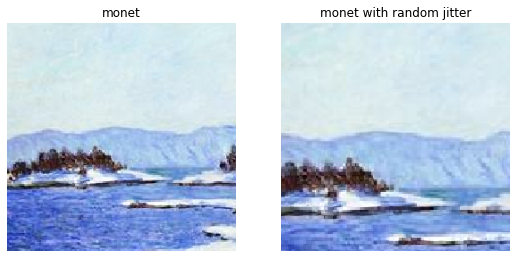

In [66]:
# Monet With  and without Random Jitter
plt.subplot(121).set_title('monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122).set_title('monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)
plt.axis('off');

(-0.5, 255.5, 255.5, -0.5)

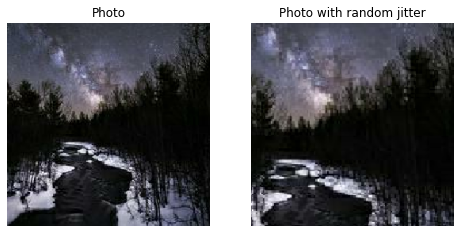

In [46]:
#photo with and without Random Jitter
plt.subplot(121).set_title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122).set_title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)
plt.axis('off');

In [47]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

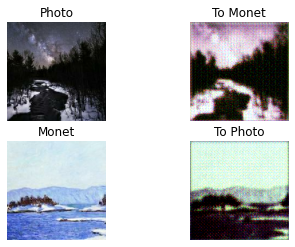

In [81]:
for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
    plt.axis('off')
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
    plt.axis('off')
plt.show()


## Loss functions

In [93]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [94]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [95]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [96]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [97]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [98]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [99]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# **Training**

In [100]:
EPOCHS = 8

In [101]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [102]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

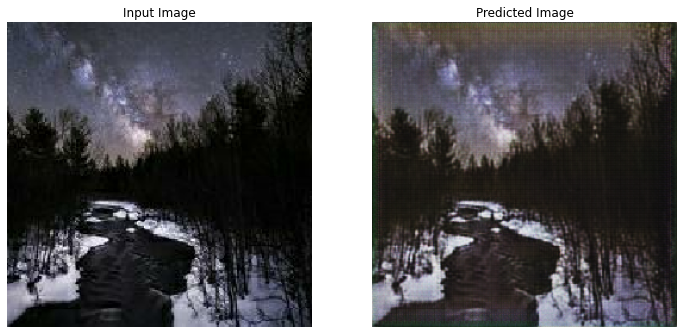

Time taken for epoch 8 is 2883.8108966350555 sec



In [103]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip(( photo_train, monet_train)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_monet) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

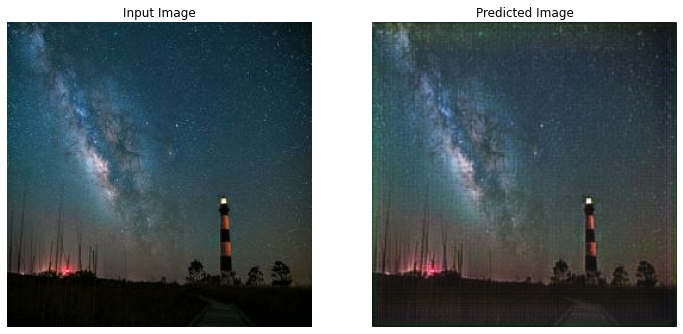

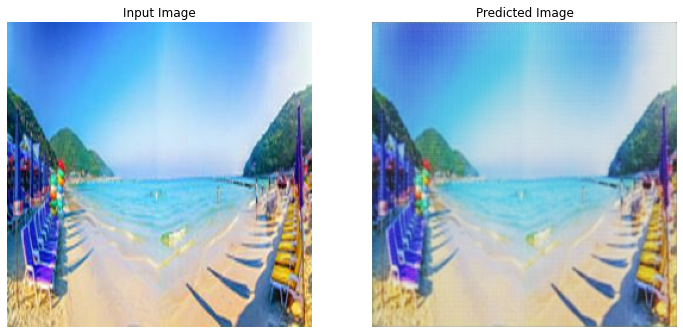

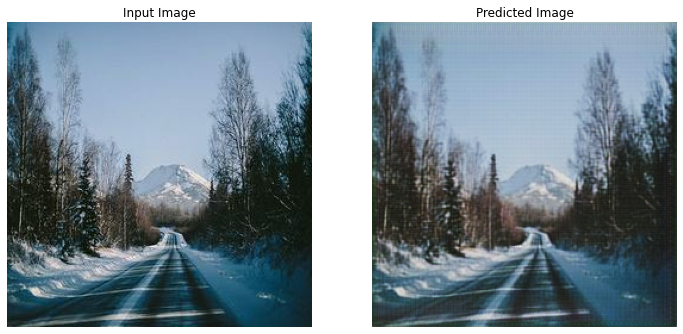

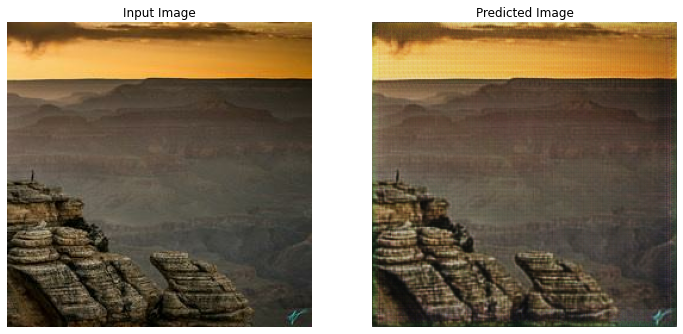

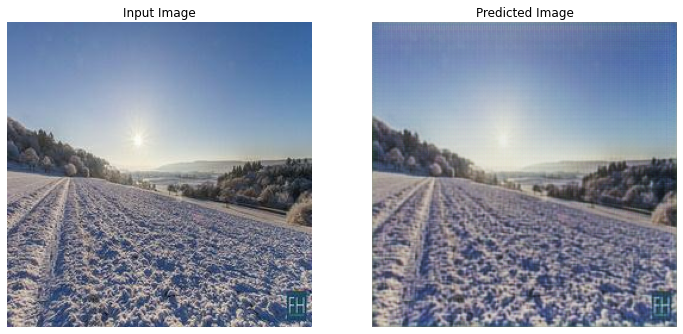

In [104]:
# Run the trained model on the test dataset
for inp in photo_test.take(5):
  generate_images(generator_g, inp)